In [1]:
%matplotlib inline
from dask import array as da
import numpy as np
import xarray as xr
from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from matplotlib import pyplot as plt
import pandas as pd
from dask import delayed

In [2]:
# parameters
dataset_version = "v2019.09.11.2"
bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"
thinning_data_factor = 0.1  # randomly thinning trajectories to 10%

In [3]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
cluster.adapt(minimum=8, maximum=40, wait_count=15)
cluster

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.63:46679 Dashboard: /user/0000-0003-1951-8494/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
def open_dataset(bucket, restrict_to_MPA=None, restrict_to_z=None):
    # load data
    gcsmap = GCSMap(bucket)
    ds = xr.open_zarr(gcsmap, decode_cf=False)
    
    # get info on starting region and make it an easy-to-look-up coord
    initial_MPA = ds.MPA.isel(obs=0).squeeze()
    ds.coords["initial_MPA"] = initial_MPA
    
    # make (non-changing) depth level an easy to look up coord
    z = ds.z.isel(obs=0).squeeze()
    ds["z"] = z
    ds.coords["z"] = ds.z
    
    # mask after land contact
    before_land_contact = ((ds.land == 0).cumprod("obs") == 1)
    ds = ds.where(before_land_contact)
    
    # add relative time
    ds["time_since_start"] = (ds.time - ds.time.isel(obs=0)) / 1e9
    
    return ds

In [6]:
ds_stokes = open_dataset(bucket_stokes)
ds_nostokes = open_dataset(bucket_nostokes)

In [9]:
def persist_z_MPA(ds):
    ds["z"] = ds["z"].persist(retries=40)
    ds["initial_MPA"] = ds["initial_MPA"].persist(retries=40)
    return ds

In [10]:
ds_stokes = persist_z_MPA(ds_stokes)
ds_nostokes = persist_z_MPA(ds_nostokes)

In [11]:
def get_z_values(ds):
    z_values = da.unique(ds.z.data).compute(retries=40)
    z_values = z_values[~np.isnan(z_values)]
    return z_values

In [12]:
z_values = get_z_values(ds_nostokes)

In [13]:
def restrict_to(ds, MPA=None, z=None):
    traj_indices = xr.full_like(ds.initial_MPA, True, dtype="bool")
    
    if MPA is not None:
        traj_indices = traj_indices & (ds.initial_MPA == MPA)
    
    if z is not None:
        traj_indices = traj_indices & (ds.z == z)
        
    ds = ds.isel(traj=traj_indices)
    
    return ds

In [14]:
from collections import OrderedDict

In [15]:
data = pd.DataFrame(
    (
        OrderedDict(
            {
                "stokes": True, "MPA": MPA, "k": k,
                "data": restrict_to(ds_stokes, MPA, z=z_values[k])
            }
        )
        for MPA in range(1, 10)
        for k in range(1)
    )
)
data = data.append(
    pd.DataFrame(
        (
            OrderedDict(
                {
                    "stokes": False, "MPA": MPA, "k": k,
                    "data": restrict_to(ds_nostokes, MPA, z=z_values[k])
                }
            )
            for MPA in range(1, 10)
            for k in range(len(z_values))
        )
    ),
    ignore_index=True
)

In [17]:
import cloudpickle

with open("all_data.pickle", "wb") as f:
    cloudpickle.dump(data, f)

In [18]:
def get_thinned_data(ds, factor=0.5, seed=None):
    if seed is ncloudpickle:
        np.random.seed(seed)
    traj_indices = (np.random.uniform(0, 1, size=ds.z.shape) < factor)
    ds = ds.isel(traj=traj_indices)
    return ds

In [19]:
data

,stokes,MPA,k,data
0,True,1,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
1,True,2,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
2,True,3,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
3,True,4,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
4,True,5,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
5,True,6,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
6,True,7,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
7,True,8,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
8,True,9,0,"[MPA, distance, land, lat, lon, temp, time, ti..."
9,False,1,0,"[MPA, distance, land, lat, lon, temp, time, ti..."


In [26]:
total_size = data["data"].apply(lambda dobj: dobj.nbytes).sum()

total_size / 1e9

552.7280924

In [32]:
data["thinned_data"] = data["data"].apply(lambda ds: get_thinned_data(ds, factor=thinning_data_factor / 10))

In [34]:
ds = data["thinned_data"][0].compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/worker.py:3177: UserWarning: Large object of size 1.17 MB detected in task graph: 
  (ImplicitToExplicitIndexingAdapter(array=LazilyOut ... 0, 962, None)))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


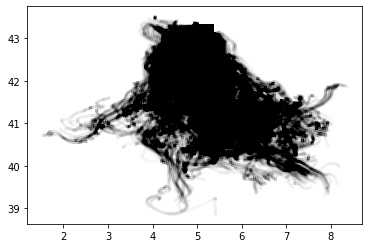

In [40]:
plt.plot(ds.lon.data.flatten(), ds.lat.data.flatten(), 'k.', alpha=0.002);

In [62]:
data = data.set_index(keys=["stokes", "MPA", "k"])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1263: FutureWarning: The `numpy.moveaxis` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1263: FutureWarning: The `numpy.moveaxis` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1263: FutureWarning: The `numpy.moveaxis` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/da

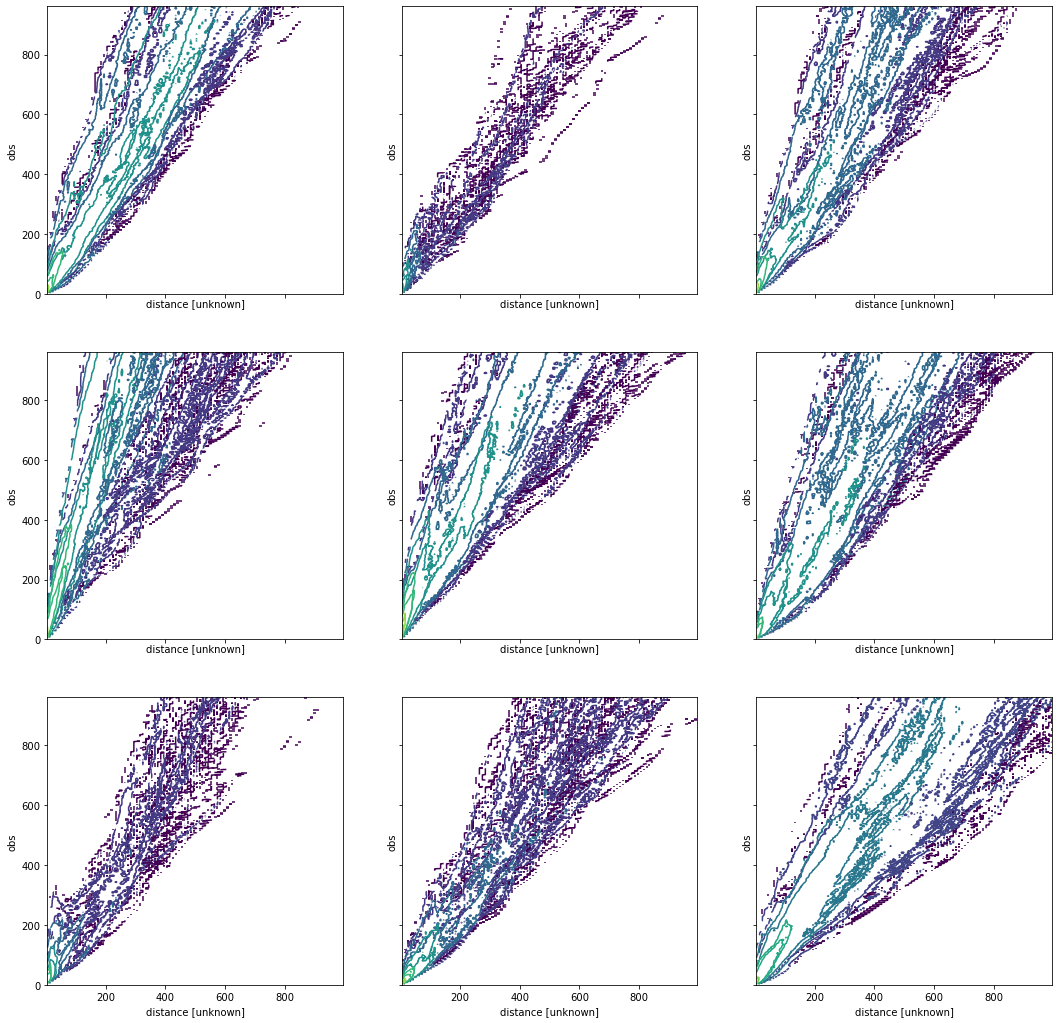

In [91]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(18, 18))

ax = ax.flatten()

for MPA, _ax in zip(range(9), ax):
    xr.ufuncs.log10(
        xhist(data.loc[True, MPA + 1, 0]["thinned_data"].distance.persist(retries=40), bins=[np.linspace(0, 1000, 101), ], dim=["traj", ]).compute(retries=40)
    ).plot.contour(ax=_ax)
    xr.ufuncs.log10(
        xhist(data.loc[False, MPA + 1, 0]["thinned_data"].distance.persist(retries=40), bins=[np.linspace(0, 1000, 101), ], dim=["traj", ]).compute(retries=40)
    ).plot.contour(ax=_ax)